# Tutorial: 4D-STEM data analysis with Hyperspy

**Bahae-eddine Mouloud, Université de Lille**

*June 21, 2023*

---

The data acquired here is of a **GaAs nanowire** displaying polymorphism between **zinc blende** and **wurtzite structures**.

In [1]:
# Import libraries

import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Forget about this cell
from IPython.display import Image, display

In [3]:
%matplotlib inline

# Outline

* What is 4D STEM
* 4D-STEM Data analysis libraries
* Example Workflows
    - Loading and Visualizing Data
    - Pre-processing of data
    - Creating Virtual Images
    - Machine learning: SVD and NMF decomposition

# 4D-STEM (10 minutes)

## NBED diffraction configuration

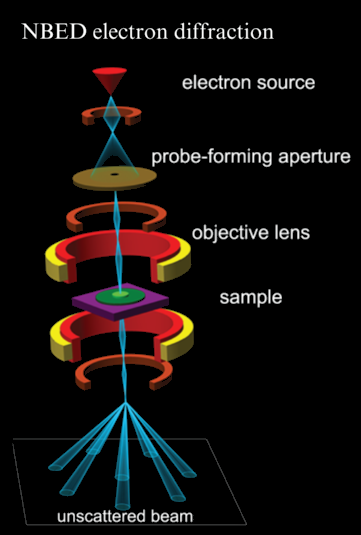

In [4]:
display(Image(filename="./NBED.png"))

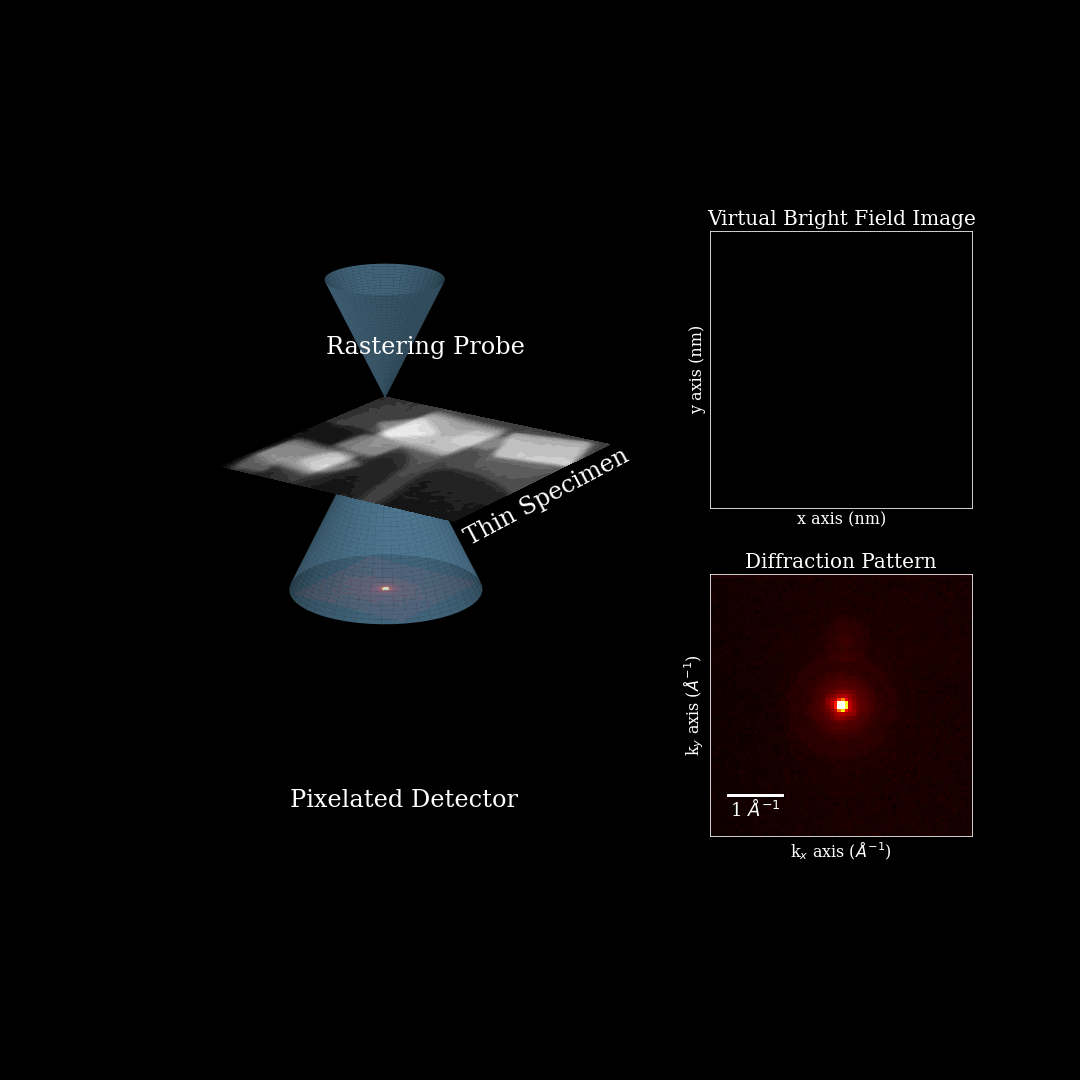

In [5]:
# Display the GIF
display(Image(filename='./4DSTEM.gif'))

## 4D-STEM data analysis softwares

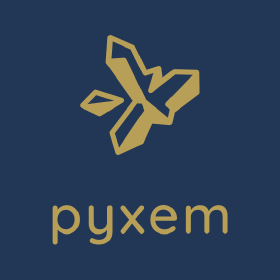

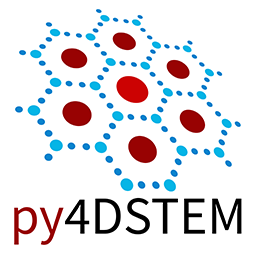

In [6]:
display(Image(filename="./pyxem.png"))
display(Image(filename="./py4DSTEM.png"))

In [7]:
hs.print_known_signal_types()

+----------------------------+---------------------+----------------------------+----------+
|        signal_type         |       aliases       |         class name         | package  |
+----------------------------+---------------------+----------------------------+----------+
|         beam_shift         |                     |         BeamShift          |  pyxem   |
|        correlation         |                     |       Correlation1D        |  pyxem   |
|        correlation         |                     |       Correlation2D        |  pyxem   |
|            dpc             |                     |       DPCBaseSignal        |  pyxem   |
|            dpc             |                     |        DPCSignal1D         |  pyxem   |
|            dpc             |                     |        DPCSignal2D         |  pyxem   |
|     DielectricFunction     | dielectric function |     DielectricFunction     | hyperspy |
|        diffraction         |                     |       Diffraction1D        |  pyxem   |
|        diffraction         |                     |       Diffraction2D        |  pyxem   |
|    diffraction_variance    |                     |   DiffractionVariance1D    |  pyxem   |
|    diffraction_variance    |                     |   DiffractionVariance2D    |  pyxem   |
|    diffraction_vectors     |                     |     DiffractionVectors     |  pyxem   |
|    diffraction_vectors     |                     |    DiffractionVectors1D    |  pyxem   |
|    diffraction_vectors     |                     |    DiffractionVectors2D    |  pyxem   |
|        tensor_field        |                     |  DisplacementGradientMap   |  pyxem   |
|          EDS_SEM           |                     |       EDSSEMSpectrum       | hyperspy |
|          EDS_TEM           |                     |       EDSTEMSpectrum       | hyperspy |
|            EELS            |       TEM EELS      |        EELSSpectrum        | hyperspy |
|    electron_diffraction    |                     |   ElectronDiffraction1D    |  pyxem   |
|    electron_diffraction    |                     |   ElectronDiffraction2D    |  pyxem   |
|          hologram          |                     |       HologramImage        | hyperspy |
| pair_distribution_function |                     | PairDistributionFunction1D |  pyxem   |
|     polar_diffraction      |                     |     PolarDiffraction2D     |  pyxem   |
|           power            |                     |          Power2D           |  pyxem   |
|     reduced_intensity      |                     |     ReducedIntensity1D     |  pyxem   |
|      vector_matching       |                     |   VectorMatchingResults    |  pyxem   |
|     virtual_dark_field     |                     |   VirtualDarkFieldImage    |  pyxem   |
+----------------------------+---------------------+----------------------------+----------+

# Data exploration - Virtual imaging - Preprocessing (25 minutes)

In [4]:
# Load data
s = hs.load("./Polymorphic_nanowire/polymorphic_nanowire.hspy", lazy=True)
s

<LazyElectronDiffraction2D, title: GaAs NW (110 zone), dimensions: (110, 160|144, 144)>

In [5]:
# Dispaly the axes manager to see the structure of your data
s.axes_manager

<Axes manager, axes: (110, 160|144, 144)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    110 |      0 |       0 |     1.1 |     nm 
               y |    160 |      0 |       0 |     1.1 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    144 |      0 |       0 |       1 | <undefined> 
              kx |    144 |      0 |       0 |       1 | <undefined>

## Espace direct - Espace réciproque

In [ ]:
# Navigate in the real space
s.plot(cmap = 'turbo')

In [ ]:
# Navigate in Diffraction space
s.T.plot(navigator_kwds = {"cmap":"turbo"})

In [6]:
## Save an image
before_preprocess = s.mean(axis = (2,3)).T
before_preprocess.metadata.General.title = "Avant pre-processing"

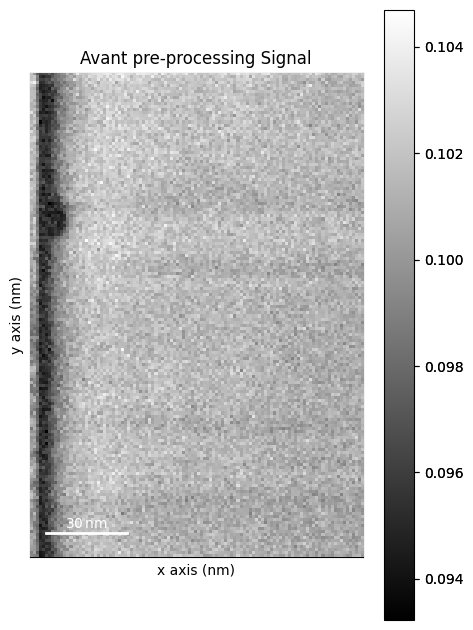

In [14]:
before_preprocess.plot()

## Pre-processing

In [15]:
# Calibrer la diffraction
diff_calib = 0.032
s.set_diffraction_calibration(diff_calib)

The DoG filter  takes advantage of the fact that noise often exhibits high-frequency content while the important features, such as the diffraction pattern in your case, tend to have lower frequencies.

By applying the DoG filter, we convolve the image with the difference of two Gaussian functions. The first Gaussian function represents a broader scale or smoothing, while the second Gaussian function represents a narrower scale or finer details.

In [16]:
from pyxem.utils.expt_utils import investigate_dog_background_removal_interactive

In [ ]:
# Perform gaussian filtering

## Take a test area
s_test_area = s.inav[59, 22]

# Define some min and max values of sigmas for gaussian filtering
max_sigmas = np.arange(2, 12, 0.2)
min_sigmas = np.arange(1, 4, 0.2)

In [ ]:
s_test_area.plot(cmap = "viridis")

In [ ]:
# Investigate the background removal with different values of min_sigmas and max_sigmas.
investigate_dog_background_removal_interactive(s_test_area, 
                                               std_dev_maxs=max_sigmas, 
                                               std_dev_mins=min_sigmas)

In [17]:
# For a given min_sigma and max_sigma, perform the background substraction
dp = s.subtract_diffraction_background('difference of gaussians',
                          min_sigma=2, max_sigma=8,
                          lazy_output=False)

/home/mouloud/miniconda3/envs/py4DSTEM/lib/python3.10/site-packages/pyxem/signals/diffraction2d.py:383: VisibleDeprecationWarning: Argument `lazy_result` is deprecated and will be removed in version 1.0.0. To avoid this warning, please do not use `lazy_result`. Use `lazy_output` instead. See the documentation of `subtract_diffraction_background()` for more details.
  name="lazy_result", alternative="lazy_output", since="0.15.0", removal="1.0.0"


[########################################] | 100% Completed | 33.41 s


In [18]:
# Normalize the data
dp.data -= dp.data.min()
dp.data = dp.data / dp.data.max()

In [19]:
## Good practices: Memory management
import gc

del s
gc.collect()

## Good practices: Data saving
# dp.save("./name_your_data.hspy")

24823

In [22]:
after_preprocess = dp.mean(axis=(2,3))
after_preprocess.metadata.General.title = "Apres pre-processing"

[<Axes: title={'center': 'Avant pre-processing'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <Axes: title={'center': 'Apres pre-processing'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

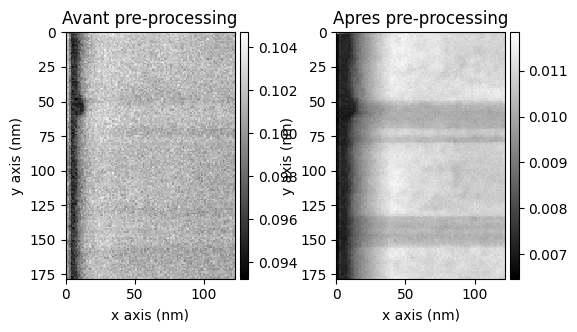

In [23]:
hs.plot.plot_images([before_preprocess, after_preprocess])

## Virtual detectors

In [ ]:
roi = hs.roi.CircleROI(cx=-0.032, cy=0, r=0.368, r_inner=0)
dp.plot_integrated_intensity(roi=roi, cmap='viridis')

In [ ]:
VI = dp.get_integrated_intensity(roi)

In [ ]:
VI.plot()

# Phase / Orientation mapping (Not covered)

- Phase and orientaion mapping are achieved by pattern matching: Pattern matching generates a database of simulated diffraction patterns and then compares all simulated patterns against each experimental pattern to find the best match

- The workflow for phase and oriention mapping is a bit long and takes a significant amount of time and computational power sometimes. An alternative approach involves performing a decomposition in 4D-STEM, which allows us to effectively extract relevant information. By subsequently conducting phase and orientation mapping on the decomposed data, we can achieve comparable results while reducing computational complexity.

# Machine learning (25 minutes)

## Preparing a subset of data
Due to constraints in computing power, We will crop the data in this tutorial to reduce its size. This ensures that the tutorial remains accessible and feasible for all users despite the limited computational ressources. Note that the exact same results can be retrieved from the whole dataset.

- To crop the data, it's better to work with an interactive backend rendering `%matplotlib qt5`

In [24]:
%matplotlib qt5

In [25]:
rect = hs.roi.RectangularROI(left=58, top=39, right=81, bottom=88)
dp.plot()
rect.add_widget(dp)

In [26]:
dp = rect(dp)

In [27]:
dp -= dp.data.min()
dp += 1e-12

## Singular Value Decomposition (SVD)

SVD is a matrix factorization technique that decomposes a given matrix into three separate matrices: U, Σ, and V. The steps to follow for an SVD decomposition are as follows:

- **4D-STEM data preprocessing and normalization**: Which we have previosuly discussed.

- **Switch to a Matrix Representation**: We represent the 4D-STEM dataset as a matrix, where each row corresponds to a diffraction pattern and each column corresponds to a specific measurement or pixel within the pattern. In this case; The matrix has a shape of $(44 \times 20, 144 \times 144)$

- **Singular Value Decomposition**: SVD breaks down the original dataset matrix into three separate matrices: *U*, *Σ*, and *V* as: $Original\_Matrix \approx U \times Σ \times V^T$.

    - **U Matrix**: The U matrix contains the left singular vectors, which represent the spatial information or the distinct diffraction patterns present in the dataset.

    - **Σ Matrix**: The Σ matrix is a diagonal matrix that contains the singular values. These singular values represent the importance or "weight" of each diffraction pattern in the dataset. The singular values are sorted in descending order, with the most significant pattern having the highest singular value.

    - **V Matrix**: The V matrix contains the right singular vectors, which represent the spectral information associated with each diffraction pattern (Phase and/or Orientation). Each column of the V matrix corresponds to a singular vector, and the values within the column describe the spectral information or distinct phases and/or orientations associated with the diffraction pattern.

**Interpretation**: The U matrix (which components are also called the factors) represents the distinct diffraction patterns, and the V matrix (which components are also called the loadings) represents the distinct phases and/or orientations associated with each pattern. By analyzing these matrices, we can extract meaningful information from the 4D-STEM dataset.

<div style="border: 2px solid black; padding: 10px;">
Diffraction Patterns: The factors represent the different diffraction patterns present in the dataset. These patterns may correspond to different crystallographic structures or sample regions with varying properties.
    
Phases and Orientations: The loadings represent the distinct phases and/or orientations associated with each diffraction pattern. By analyzing these columns, we can identify different crystallographic phases or orientations present in the sample.
</div>


**Data Reconstruction**: SVD allows us to reconstruct the original dataset by selecting a subset of the singular values, corresponding singular vectors, and diffraction patterns. This reconstruction can help us visualize and analyze specific components of the dataset.

In [28]:
dp.decomposition(True, algorithm="SVD")

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


<Axes: title={'center': 'GaAs NW (110 zone)\nPCA Scree Plot'}, xlabel='Principal component index', ylabel='Proportion of variance'>

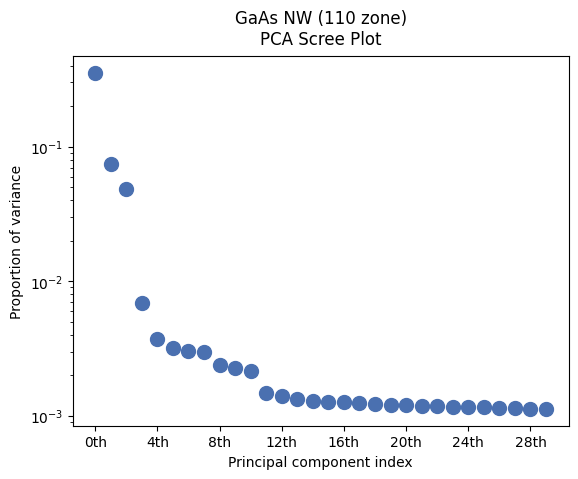

In [30]:
%matplotlib inline
dp.plot_explained_variance_ratio()

In [31]:
%matplotlib qt5
dp.plot_decomposition_results()

[<Axes: >]

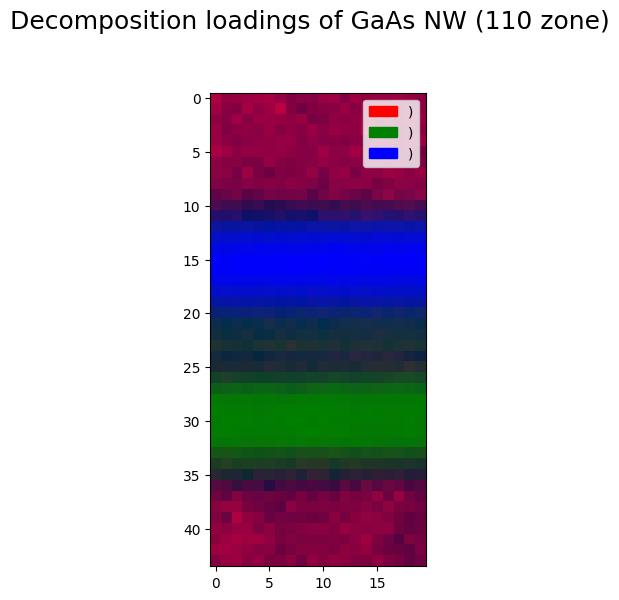

In [33]:
%matplotlib inline
SVD_loadings = [dp.get_decomposition_loadings().inav[i] for i in range(3)]
hs.plot.plot_images(SVD_loadings, overlay=True, colors = ["red","green","blue","yellow"])

[<Axes: xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>]

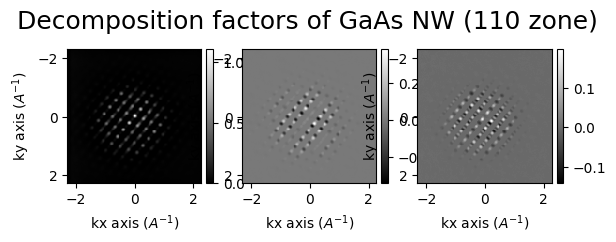

In [32]:
%matplotlib inline
SVD_factors = [dp.get_decomposition_factors().inav[i] for i in range(3)]
hs.plot.plot_images(SVD_factors, overlay=False)

In [ ]:
# %matplotlib qt5
SVD_factors = [dp.get_decomposition_factors().inav[i] for i in range(3)]
hs.plot.plot_images(SVD_factors, overlay=True)

## Non-Negative Matrix Factorization (NMF)

NMF is a matrix factorization technique that decomposes a given matrix into two nonnegative matrices: W and H. Here are the steps involved in NMF decomposition:

- **4D-STEM data preprocessing and normalization**: Similar to SVD, we preprocess and normalize the 4D-STEM dataset before applying NMF.

- **Switch to a Matrix Representation**: We represent the 4D-STEM dataset as a matrix, where each row corresponds to a diffraction pattern, and each column corresponds to a specific measurement or pixel within the pattern. The matrix has a shape of  $(44 \times 20, 144 \times 144)$, same as in SVD.

- **Nonnegative Matrix Factorization**: NMF decomposes the original dataset matrix into two nonnegative matrices, W and H, such that: $Original\_Matrix \approx W \times H$.

    - **W Matrix**: The W matrix contains the nonnegative basis vectors, which represent the spatial information or the distinct diffraction patterns present in the dataset. Each column of the W matrix corresponds to a basis vector, and the values within the column describe the spatial distribution of the diffraction pattern.

    - **H Matrix**: The H matrix contains the nonnegative coefficient matrix, which represents the contribution of each basis vector to reconstruct the original dataset. Each column of the H matrix corresponds to a basis vector's coefficients, and the values within the column describe the weights or importance of each basis vector in the reconstruction process.

- **Interpretation**: The W matrix represents the distinct diffraction patterns in the dataset, similar to the U matrix in SVD. The H matrix represents the contribution of each diffraction pattern in reconstructing the original dataset, similar to the V matrix in SVD.
<div style="border: 2px solid black; padding: 10px;">
Diffraction Patterns: The basis vectors in the W matrix represent the different diffraction patterns present in the dataset, similar to the factors in SVD. These patterns may correspond to different crystallographic structures or sample regions with varying properties.
Contribution and Weights: The coefficient matrix H describes the contribution or importance of each basis vector (diffraction pattern) in reconstructing the original dataset. By analyzing the columns of the H matrix, we can understand the relative importance and weights of the different diffraction patterns in the dataset.

</div>

- **Data Reconstruction**: NMF allows us to reconstruct the original dataset by multiplying the W and H matrices. By selecting a subset of basis vectors (columns) from W and their corresponding coefficients from H, we can reconstruct specific components or features of the dataset.

It's important to note that NMF enforces nonnegativity constraints on the factors, which can be beneficial in certain applications where the data has a nonnegative nature.

In [34]:
dp.decomposition(True, algorithm="NMF", output_dimension=3)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=3
  centre=None
scikit-learn estimator:
NMF(n_components=3)


In [35]:
%matplotlib qt5
dp.plot_decomposition_results()

[<Axes: >]

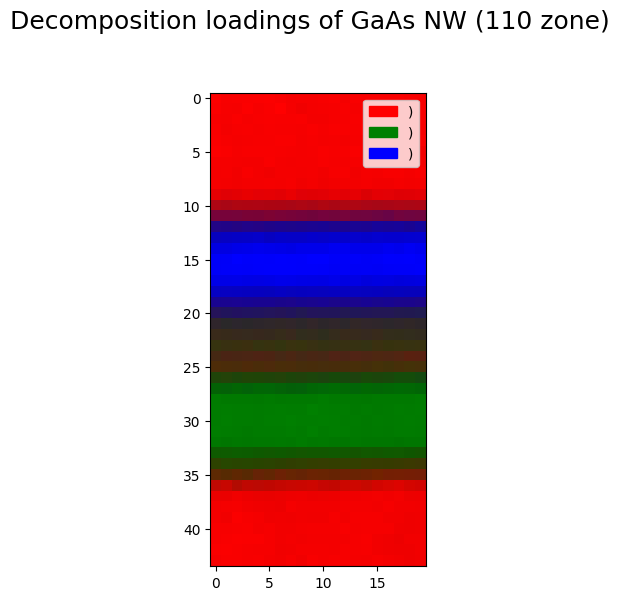

In [37]:
%matplotlib inline
NMF_loadings = [dp.get_decomposition_loadings().inav[i] for i in range(3)]
hs.plot.plot_images(NMF_loadings, overlay=True, colors = ["red","green","blue"])

- Our **Zinc Blind** structure is the reddish one and our **Wurtzite** is in green and blue (2 different orientations)

[<Axes: xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <Axes: xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>]

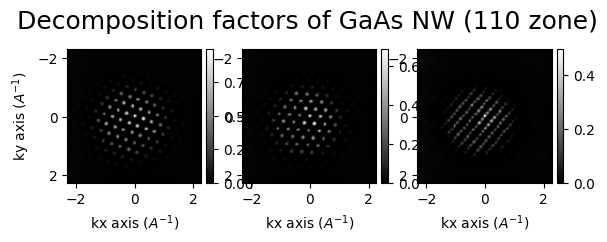

In [38]:
%matplotlib inline
NMF_factors = [dp.get_decomposition_factors().inav[i] for i in range(3)]
hs.plot.plot_images(NMF_factors, overlay=False)

[<Axes: >]

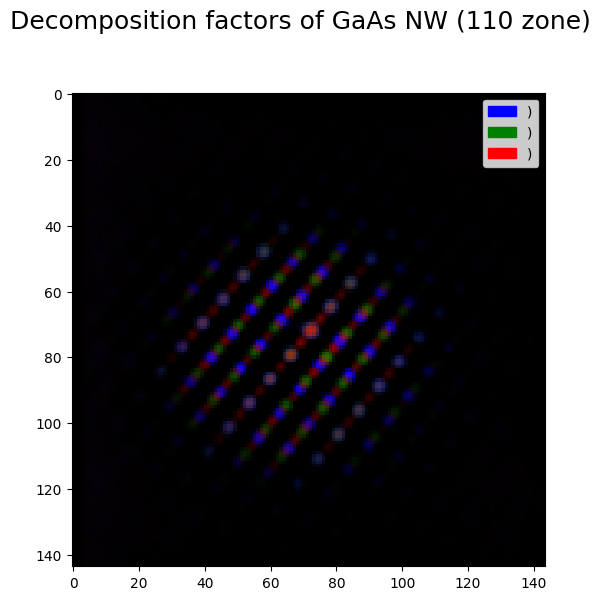

In [46]:
# %matplotlib inline
NMF_factors = [dp.get_decomposition_factors().inav[i] for i in range(3)]
hs.plot.plot_images(NMF_factors, overlay=True, vmax=0.6)

In [47]:
dp.save("/home/mouloud/Desktop/data.hspy")

In [ ]:
dp.mean(axis=(2,3)).plot()

# Last remarks
- We can perform the same analysis using radial profiles rather than diffraction patterns simply by integrating all the diffraction patterns in the stack
- We can also perform any kind of analysis we want on radial profiles (for those who are more familiar with spectra)

## Bonus example: radial integration

In [10]:
%matplotlib inline

In [ ]:
s = dp.inav[5,5].deepcopy()

s.beam_energy = 200
s.unit = 'k_A^-1'
s.set_ai()

In [ ]:
# not is The number of radial points to calculate
s_radial = s.get_azimuthal_integral1d(npt = 800)

In [ ]:
s_radial.plot()

In [ ]:
dp.beam_energy = 200
dp.unit = 'k_A^-1'
dp.set_ai()

In [ ]:
dp_radial = dp.get_azimuthal_integral1d(npt = 800)

In [ ]:
%matplotlib qt5
dp_radial.T.plot()

---
The end